This file / kernel only is focusing on using `(S)ARIMA` model to predict the `time_series` in the dataset `XTX_data.csv`!!

Hence, we only consider the target (or the series) and ignore all the input features!

Noting that, I have solved the model using all the input features in another kernel; such as :
> (XGBoost): [XGBoost.model](https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/Time_series/XTX%20Challenge/XTX_challenge%20using%20XGBoost.ipynb)
>
> (LSTM): [LSTM-RNN-GRU.model](https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/Time_series/XTX%20Challenge/XTX_challenge%20using%20LSTM.ipynb)

Again. First of all, looking back the dataset before going to analyze the ARIMA model!

In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
%time df = pd.read_csv(r"D:\Nhan\Data\XTX_data.csv")

print(df.shape)
df.head(10)

Wall time: 20.2 s
(2999999, 61)


,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,...,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,y
0,1619.5,1620.0,1621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
1,1619.5,1620.0,1621.0,1621.5,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
2,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
3,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
4,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
5,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
6,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
7,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,1623.5,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
8,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,1623.5,1624.0,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
9,1619.5,1620.0,1621.0,1621.5,1622.0,1623.0,1623.5,1624.0,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5


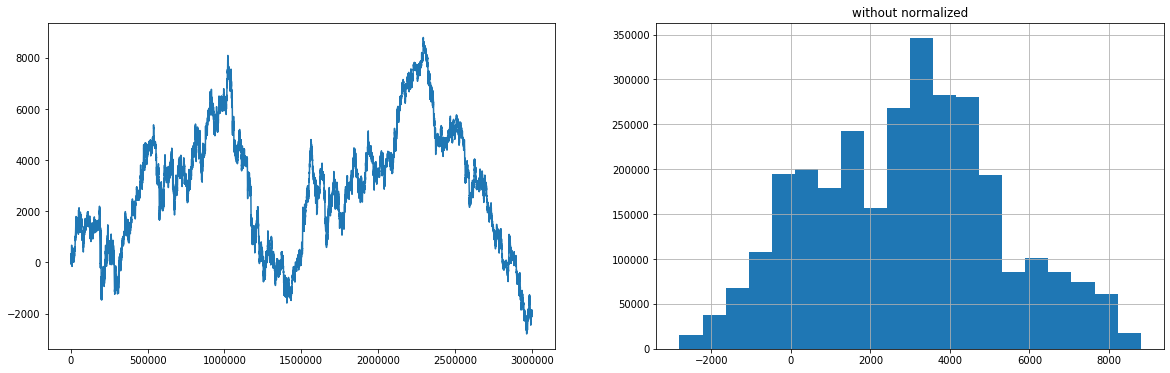

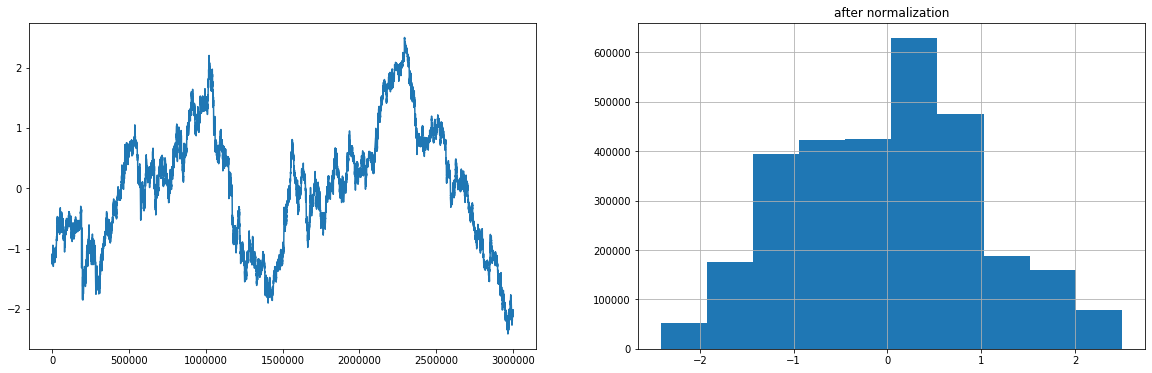

In [3]:
series = df.y.cumsum()
x = series.copy()
x -= x.mean()
x /= x.std()

fig, axes = plt.subplots(1, 2, figsize = (20, 6))
series.plot(ax = axes[0]); axes[1].set_title('without normalized')
series.hist(bins = 20, ax = axes[1]);

fig, axes = plt.subplots(1, 2, figsize = (20, 6))
x.plot(ax = axes[0]); axes[1].set_title('after normalization')
x.hist(ax = axes[1])

The `line-plot` and `histogram` show that the series has `non-zero mean` and it **doesn't look like a `Gaussian`**. To verifty this, we will use `ADF test`

## 1. Checking stationary by using `ADF test`

In [4]:
result = adfuller(x)
print('\tADF Statistic: %f' % result[0])
print('\tp-value: %f' % result[1])
print('\tCritical Values:')
for key, value in result[4].items():
    print('\t\t%s: %.3f' % (key, value))

	ADF Statistic: -1.609896
	p-value: 0.478620
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567


Hence, after normalizing, we can see that the series look like stationary; and thanks for `ADF test`, for $\alpha = 0.05 >$ `p_value` then the `normalized_series` is `non-stationary` again!

## 2. Finding the params `d, p, q`

The full explaination of model ARIMA had been writen in the following link: 
[ARIMAv&SARIMA.model](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/Discussions/time_series_forecasting/Time_series_forecasting_ARIMAvsSARIMA.ipynb)

### 2.1. Find the differencing term `d`

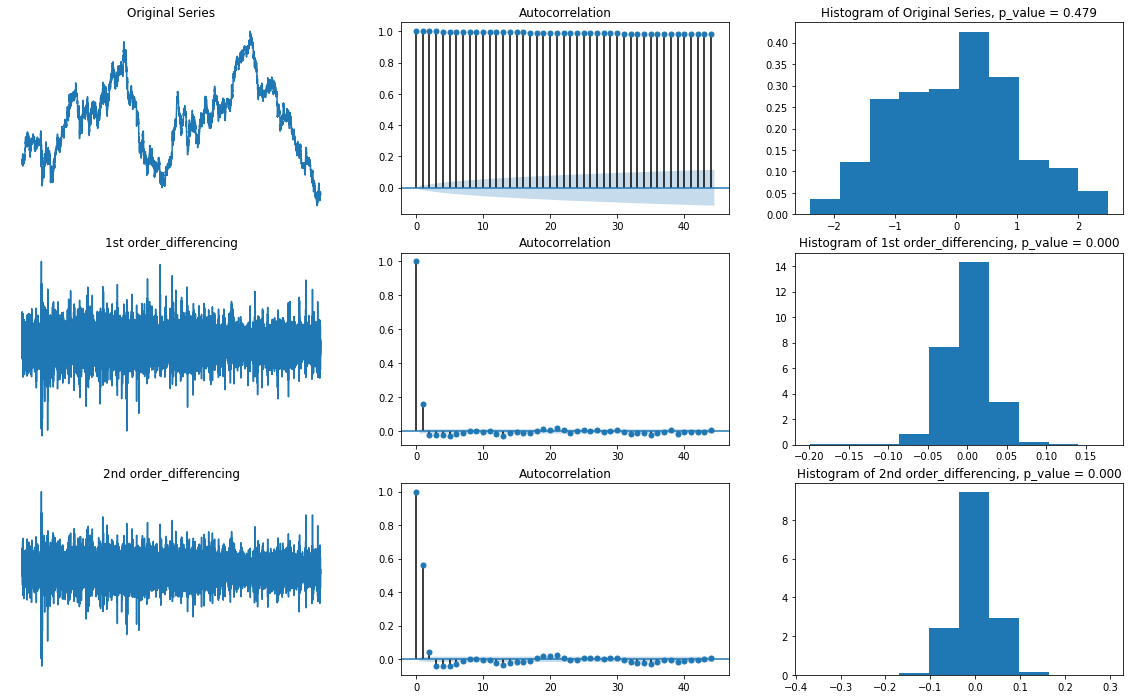

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

Series = pd.Series(x)
titles = ['Original Series', '1st order_differencing', '2nd order_differencing']
fig, axes = plt.subplots(3, 3, figsize = (20, 12))
for k in [0, 1, 2]:
    time_series = [Series, Series.diff(1), Series.diff(2)]
    axes[k, 0].plot(time_series[k].values)
    axes[k, 0].set_title(titles[k])
    axes[k, 0].set_axis_off()
    result = adfuller(time_series[k].dropna())
    plot_acf(time_series[k].dropna(), ax = axes[k, 1])
    axes[k, 2].hist(time_series[k].dropna(), density = True)
    axes[k, 2].set_title('Histogram of %s, p_value = %.3f'%(titles[k], result[1]))

So, look at the `autocorrelation plot` we can fix the order of differencing as **`d = 2`** or **`d = 1`** also. But firstly, assume that we tentatively fix **d = 2**

Noting that, we must set the statement `.dropna()` very time using `series.diff(k)` to ignore the `NaN's values` when `differencing`.

In [6]:
len(Series), len(Series.diff(1).dropna()), len(Series.diff(2).dropna())

(2999999, 2999998, 2999997)

**Using `arima.utils.ndiffs`** to verify the choosing `d`

In [7]:
from pmdarima.arima.utils import ndiffs
crits = ['adf', 'kpss', 'pp']
for crit in crits:
    print('criteria = "%s", ndiff = %s'%(crit, ndiffs(Series, test = crit)))

criteria = "adf", ndiff = 1
criteria = "kpss", ndiff = 1
criteria = "pp", ndiff = 1


### 2.2. Find the `AR's terms` by using `pacf` or `Partial Autocorrelation function`

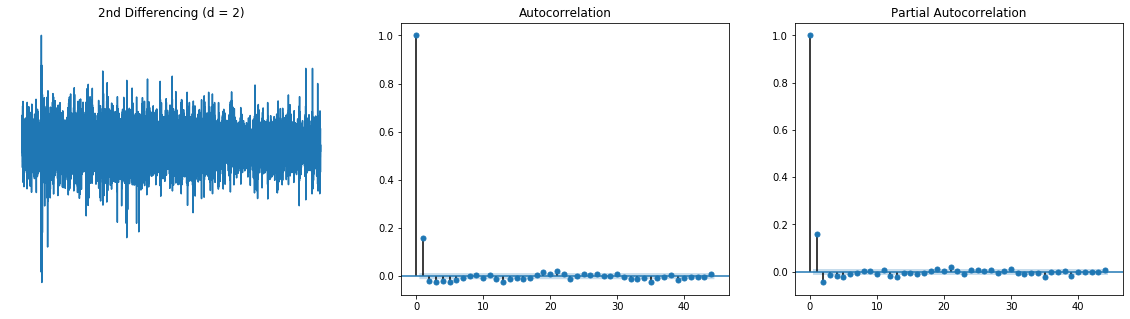

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1, 3, figsize = (20, 5))
axes[0].plot(Series.diff(2)); axes[0].set_title('2nd Differencing (d = 2)')
axes[0].set_axis_off()
plot_acf(Series.diff().dropna(), ax=axes[1])
plot_pacf(Series.diff().dropna(), ax=axes[2])
plt.show()

We can observe that
> The `PACF lag 1` is quite significant since is well above the `significance line` (`blue region`). 
>
> `PACF Lag 2` turns out to be significant as well, slightly managing to cross the significance limit (blue region), while, 
>
> `PACF lag 3` is bellow the significant line.

But we am going to be conservative and tentatively fix the **`p = 1`**.


### 2.3 Find the `MA's terms` by looking back the `acf` of `series.diff(d)`

> Just like how we looked at the `PACF plot` for the number of AR terms,
>
> we can look at the `ACF plot` for the number of `MA terms`. An `MA term` is technically, the error of the lagged forecast.

The `ACF` tells how many `MA terms` are required to remove any autocorrelation in the stationarized series.

Look at preceding_line, (at autocorrelation terms), we tentatively fix **`q = 2`**

## 3. Starting with `ARIMA's model (p, d, q)`

Hence, we are tentatively using the model **`ARIMA, order(p = 1, d = 2, q = 2)`**

In [9]:
model = ARIMA(Series.values, order=(1,2,2))
model_fit = model.fit(disp = 0)
model_fit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-6.975e-08,5.91e-07,-0.118,0.906,-1.23e-06,1.09e-06
ar.L1.D2.y,-0.2151,0.025,-8.578,0.000,-0.264,-0.166
ma.L1.D2.y,-0.6234,0.020,-30.569,0.000,-0.663,-0.583
ma.L2.D2.y,-0.3723,0.024,-15.317,0.000,-0.420,-0.325


We’ll focus our attention on the `table of coefficients`. The `coef column` shows the `weight` (i.e. importance) of each feature and how each one impacts the time series. 

The `P>|z|` column informs us of the significance of each `feature weight`. Here, each weight has a `p-value` lower or close to 0.05 (excepting the `constant`), so it is reasonable to retain all of them (the `AR & MA's terms`) in our model.

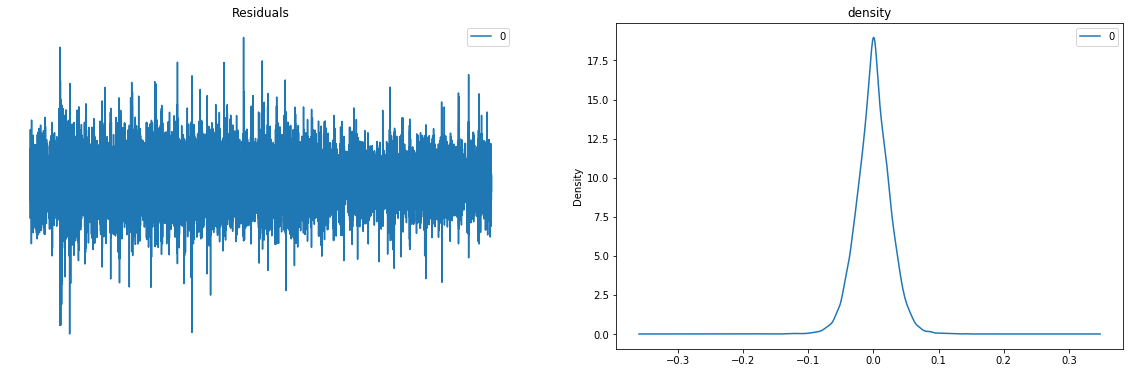

In [10]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
residuals.plot(title = "Residuals", ax = ax[0])
ax[0].set_axis_off()
residuals.plot(kind = 'kde', title = 'density', ax = ax[1])
plt.show()


Noting that the `dynamic` keyword affects in-sample prediction. If dynamic        is **`False`**, then the in-sample lagged values are used for        prediction. 

If `dynamic` is **`True`**, then in-sample forecasts are  used in place of lagged dependent variables. The first forecast    value is `start`.


The statement **`plot_insample = False`** only returns the plot of forecasting!

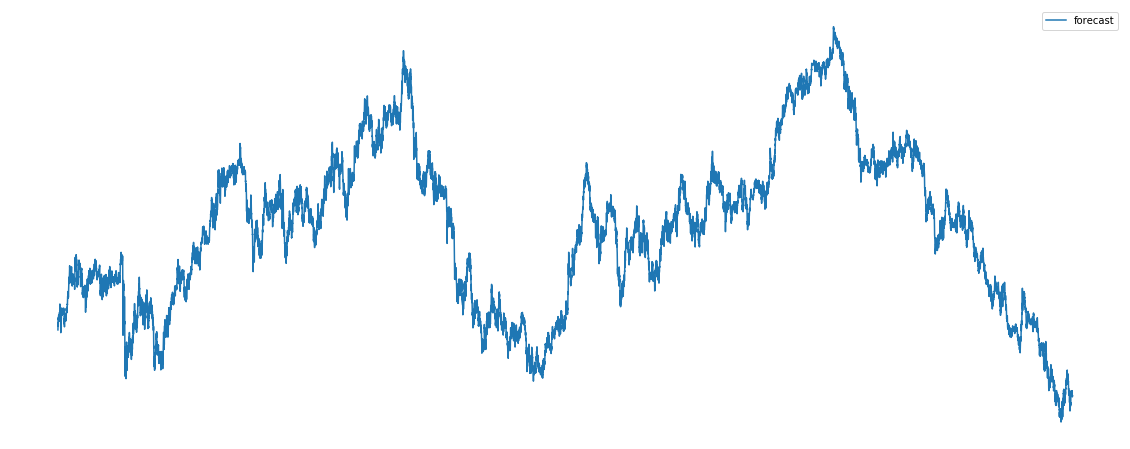

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
model_fit.plot_predict(dynamic=False, ax = ax, alpha = 0.01, plot_insample = False)
ax.set_axis_off()
plt.show()

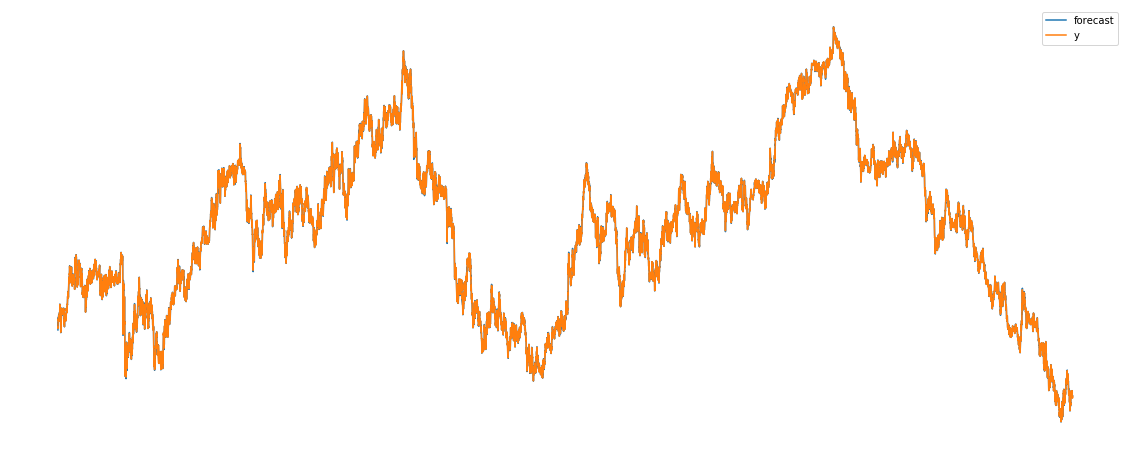

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
model_fit.plot_predict(dynamic=False, ax = ax, alpha = 0.01, plot_insample = True)
ax.set_axis_off()
plt.show()

### Apply train_test_split

In [13]:
train_size = int(0.8*len(Series))
train = Series[: train_size]
test = Series[train_size : ]
test_size = len(test)
model = ARIMA(train.values, order=(1, 2, 2))  
fitted = model.fit(disp=0)  
fitted.summary().tables[1]

C:\Users\Admin\.conda\envs\projecy\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\Admin\.conda\envs\projecy\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Admin\.conda\envs\projecy\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Admin\.conda\envs\projecy\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Admin\.conda\envs\projecy\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


,coef,std err,z,P>|z|,[0.025,0.975]
const,-1.454e-07,1.47e-06,-0.099,0.921,-3.03e-06,2.74e-06
ar.L1.D2.y,-0.1135,0.020,-5.569,0.000,-0.153,-0.074
ma.L1.D2.y,-0.6929,0.013,-52.022,0.000,-0.719,-0.667
ma.L2.D2.y,-0.2985,0.021,-13.896,0.000,-0.341,-0.256


### Viewing plot

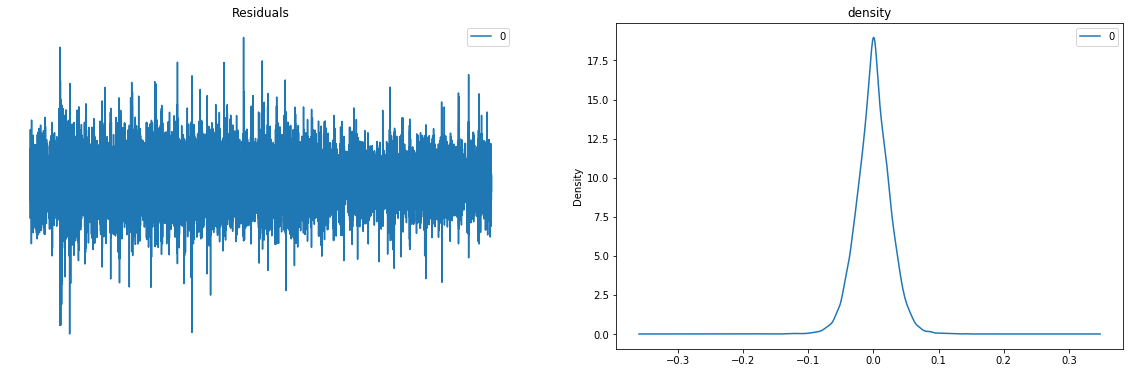

In [14]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
residuals.plot(title = "Residuals", ax = ax[0])
ax[0].set_axis_off()
residuals.plot(kind = 'kde', title = 'density', ax = ax[1])
plt.show()

### Forecast

In [15]:
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=test.index)

### Visualization forecasting

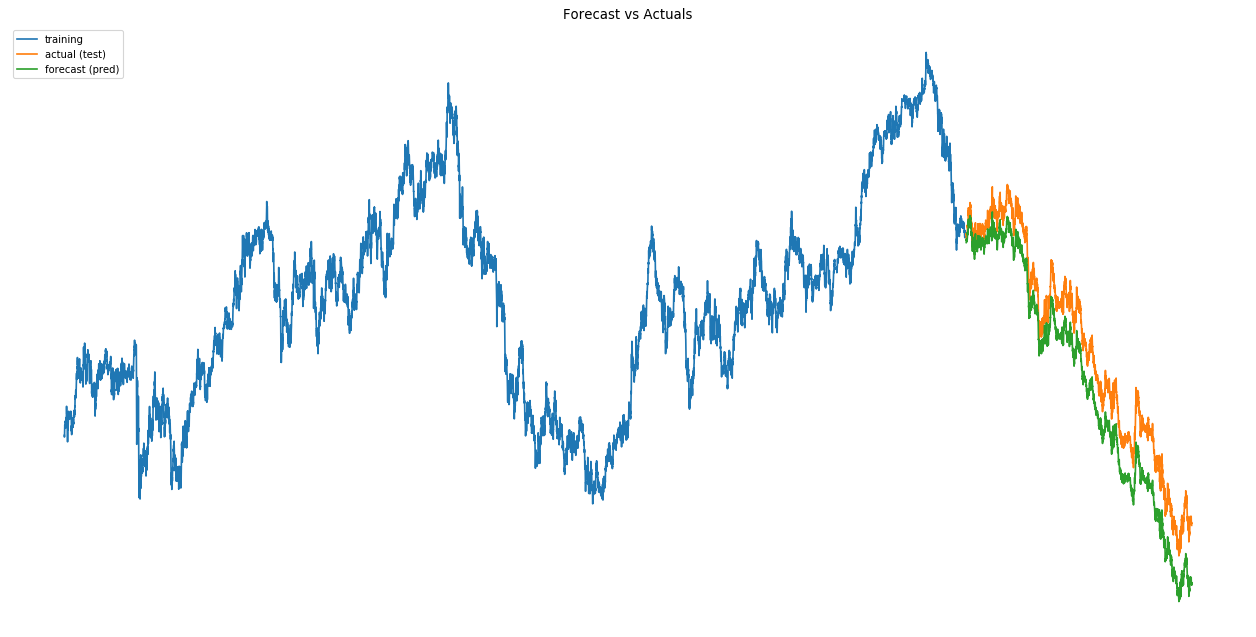

In [16]:
plt.figure(figsize=(20, 10), dpi = 80)
plt.plot(train, label='training')
plt.plot(test, label='actual (test)')
plt.plot(fc_series, label='forecast (pred)')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=9)
plt.axis("off")
plt.show()

**How about the metric?**

In [17]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)                        # ME
    mae = np.mean(np.abs(forecast - actual))               # MAE
    rmse = np.mean((forecast - actual)**2)**.5             # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]              # corr
    acf1 = acf(forecast - actual, fft = False)[1]          # ACF1
    return({'me':me, 'mae': mae, 
            'rmse':rmse, 'acf1':acf1, 
            'corr':corr})

forecast_accuracy(fc, test.values)

{'me': -0.34124212839816087,
 'mae': 0.34124212839816087,
 'rmse': 0.36465518468526315,
 'acf1': 0.998535181282234,
 'corr': 0.9978445400664909}

### How about using SARIMA?

In this dataset, we can see that this is too difficult to guess the `period`; because we didn't know the `time-stamp`

However, looking at the series.plot; we can see that the series seems repeated after `1/2 whole process`!! So in this case, we only try using `SARIMA` to verify this and we don't expect that it can be improved!

In [18]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model_2 = pm.auto_arima(Series.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_2.summary().tables[1]

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-111660.413, BIC=-111627.907, Time=4.405 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-110977.510, BIC=-110961.256, Time=3.733 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-111619.210, BIC=-111594.830, Time=2.824 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-111659.095, BIC=-111634.715, Time=3.793 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-110979.465, BIC=-110971.339, Time=1.151 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-111677.028, BIC=-111636.395, Time=10.841 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-111669.203, BIC=-111636.697, Time=2.870 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-111660.773, BIC=-111612.013, Time=19.157 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-111660.532, BIC=-111619.899, Time=33.818 seconds
Total fit time: 82.666 seconds


,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-2.686e-05,0.000,-0.237,0.813,-0.000,0.000
ar.L1,0.4761,0.101,4.733,0.000,0.279,0.673
ar.L2,-0.0949,0.015,-6.312,0.000,-0.124,-0.065
ma.L1,-0.3100,0.101,-3.081,0.002,-0.507,-0.113
sigma2,0.0007,4.45e-06,150.991,0.000,0.001,0.001


The `AIC` minimized at model `ARIMA(???)`

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

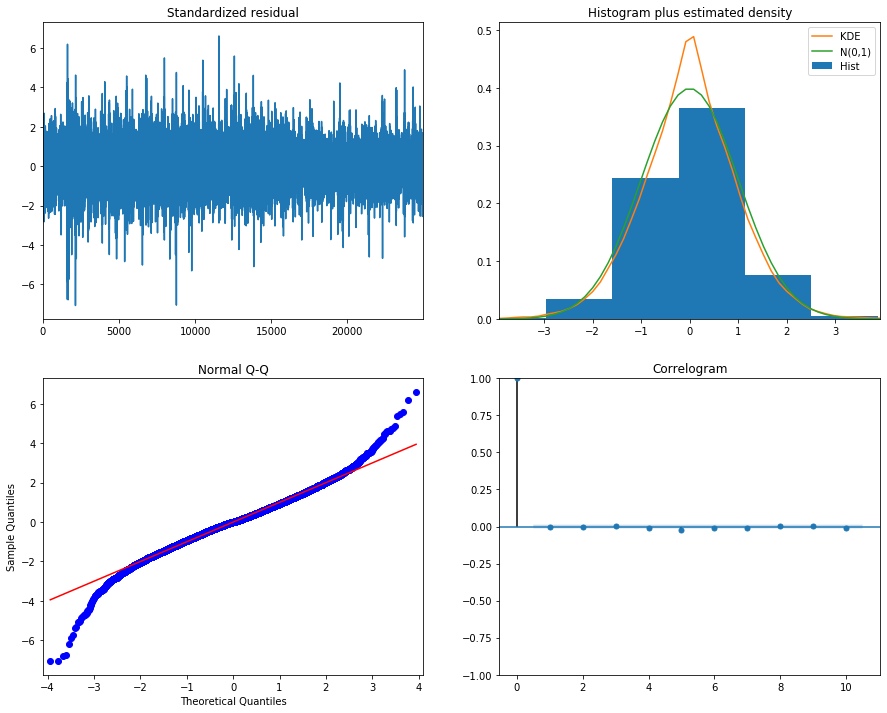

In [19]:
model_2.plot_diagnostics(figsize=(15, 12))
plt.show()

Our `primary concern` is to ensure that the residuals of our model are `uncorrelated` and `normally distributed with zero-mean`. If the `seasonal ARIMA model` does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

>In the **`top right`** plot, we see that the `red KDE line` follows closely with the $N(0,1)$ line (where $N(0,1)$) is the standard notation for a `normal distribution` with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
>
>The **`qq-plot`** on the **`bottom left`** shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with $N(0, 1)$. Again, this is a strong indication that the residuals are normally distributed.
>
>The `residuals` over time (**`top left`** plot) doesn't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the **`bottom right`**, which shows that excepting `lag 1`, the time series residuals have low correlation with lagged versions of itself (after lag 2).

(-1249.95, 26248.95, -5.231419939422825, 3.578605439041248)

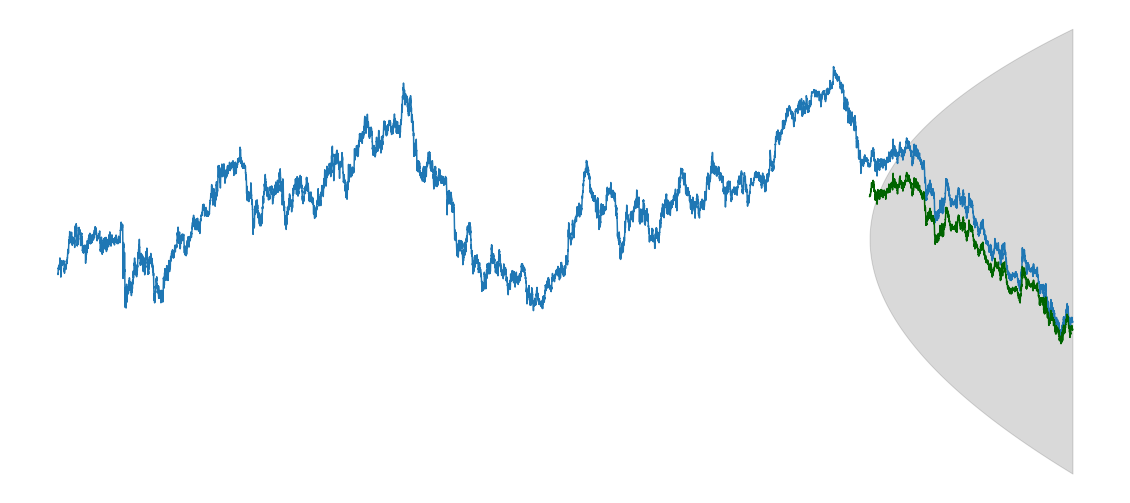

In [20]:
n_periods = len(test)
fc, confint = model_2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(Series) - n_periods, len(Series))

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (20, 9))
plt.plot(Series)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.axis("off")

In [21]:
forecast_accuracy(fc, test.values)

{'me': -0.38960080488787424,
 'mae': 0.38960080488787424,
 'rmse': 0.4162764846649755,
 'acf1': 0.9993340908155531,
 'corr': 0.9999932801429842}

We can see that the `MAE` and `RMSE` has been increased and these approaches still worse, compared with using `XGBoost's model`